In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import math
from scipy.stats import chi2
import seaborn as sns

# Générateur pseudo-aléatoire

## Question 1:

Python utilise le génerateur pseudo-aléatoire Mersene-Twister afin de générer une suite de nombres pseudo-aléatoires selon la loi uniforme $\mathcal{U}\left(\left[0, 1 \right] \right)$

## Question 2:

Si on veut générer deux fois la même suite de nombres pseudo-aléatoires selon la loi uniforme $\mathcal{U}\left(\left[0, 1\right] \right)$ il faut qu'on fixe la valeur de la graine.

Fixons la graine avec la valeur $0$ et générons une première séquence de $10$ nombres.

In [2]:
random.seed(0)
for i in range(10):
    print(random.random())

0.8444218515250481
0.7579544029403025
0.420571580830845
0.25891675029296335
0.5112747213686085
0.4049341374504143
0.7837985890347726
0.30331272607892745
0.4765969541523558
0.5833820394550312


Générons mainetenant la deuxième séquence en n'oubliant pas de fixer la graine à $0$

In [3]:
random.seed(0)
for i in range(10):
    print(random.random())

0.8444218515250481
0.7579544029403025
0.420571580830845
0.25891675029296335
0.5112747213686085
0.4049341374504143
0.7837985890347726
0.30331272607892745
0.4765969541523558
0.5833820394550312


En effet, on a reproduit exactement la même séquence de $10$ nombres pseudo-aléatoires.

# Méthode d'acceptation-rejet

## Question 1:

On veut simuler la variable aléatoire réelle $X$ de densité:
$$
f(x) \propto exp\left(\frac{-\left(x - 1 \right)^2}{2} \right)|sin\left(\pi x \right)| \le exp\left(\frac{-\left(x - 1 \right)^2}{2} \right)
$$
Soit $g\left(x \right) = exp\left(\frac{-\left(x - 1 \right)^2}{2} \right) \forall x \in \mathbb{R}$, $g$ est la densité de la distribution normale $\mathcal{N}\left(1, 1 \right)$ qu'on sait simuler.

On peut donc utiliser la méthode d'acceptation-rejet pour simuler la variable aléatoire $X$

In [4]:
def simulate(n):
    """
    Description
    --------------
    This function simulates the random variable X n times.
    
    Parameters
    --------------
    n : Int, the number of samples we want.
    
    Returns
    --------------
    List of length n containing the n samples of X
    """
    
    samples = []
    i = 0
    while i < n:
        y = random.normalvariate(1, 1)
        u = random.random()
        if u <= abs(math.sin(math.pi*y)):
            samples.append(y)
            i += 1
            
    return samples
    

Voici un exemple de $10$ réalisations de la distribution $f$

In [5]:
l = simulate(10)
l

[2.413507790048121,
 2.149904520521952,
 1.5979448492237212,
 2.530575803609813,
 1.8340720033925317,
 1.7856692192431391,
 1.9421813941891228,
 -0.4945914152578761,
 1.43866126697404,
 1.2708225851883133]

Testons le temps qu'il faut pour avoir un grand échantillon de réalisations de $f$

In [6]:
%%timeit
simulate(1e6)

3.91 s ± 305 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Générer $10^6$ échantillons prend en moyenne moins de $4s$, ceci est dû au fait que $f$ et $g$ étant très similaires, la constante de domination est petit ($1$ ici) et on se retrouve avec un grand taux d'acceptation.

# Algorithme de Metropolis-Hastings

## Question 1

In [2]:
x0 = .0
nsamples = 50000
logpdf = lambda x : chi2.logpdf(x, 3)
proprnd = lambda s, x : x + s*np.random.normal()

In [3]:
def mhsim(s, x0, nsamples, logpdf, proprnd):
    
    """
    Description
    --------------
    This function simulates an MCMC with Metropolis-Hastings in order to get samples from the distribution
    of log-probability distribution function logpdf.
    
    Paramaters
    --------------
    s        : Float, the standard deviation of the proposal distribution.
    x0       : Float, the initial state.
    nsamples : Int, the number of samples to generate.
    logpdf   : function, the log-probability distribution of the target distribution.
    proprnd  : function, the function that proposes the next value of the markov chain.
    
    Returns
    --------------
    samples  : List containing the simulated samples.
    rho_mean : Float, the mean acceptance ratio.
    """
    
    x = x0
    samples = [x]
    rho_mean = 0
    for i in range(1, nsamples):
        y = proprnd(s, x)
        rho = min(1, math.exp(logpdf(y) - logpdf(x)))
        if rho >= 1:
            x = y
            
        else:
            u = np.random.binomial(1, rho)
            x = u*y + (1 - u)*x
            
        samples.append(x)
        rho_mean += rho
        
    return samples, rho_mean/(nsamples - 1)

In [13]:
samples1, rho_mean1 = mhsim(1e-3, x0, nsamples, logpdf, proprnd)
samples2, rho_mean2 = mhsim(1, x0, nsamples, logpdf, proprnd)

C:\Users\Jarvis\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


## Question 2

In [14]:
print('acceptance rate for s = 1e-3 : %.3f' %rho_mean1)
print('acceptance rate for s = 1 : %.3f' %rho_mean2)

acceptance rate for s = 1e-3 : 0.996
acceptance rate for s = 1 : 0.812


Pour $s = 10^{-3}$, il est normal que le taux d'acceptation soit si grand, vu qu'avec $s = 10^{-3}$ on reste très proche du point depuis lequel on simule le prochain point de la chaîne de Markov, ceci implique que $\rho$ (le taux d'acceptation) reste proche de $1$

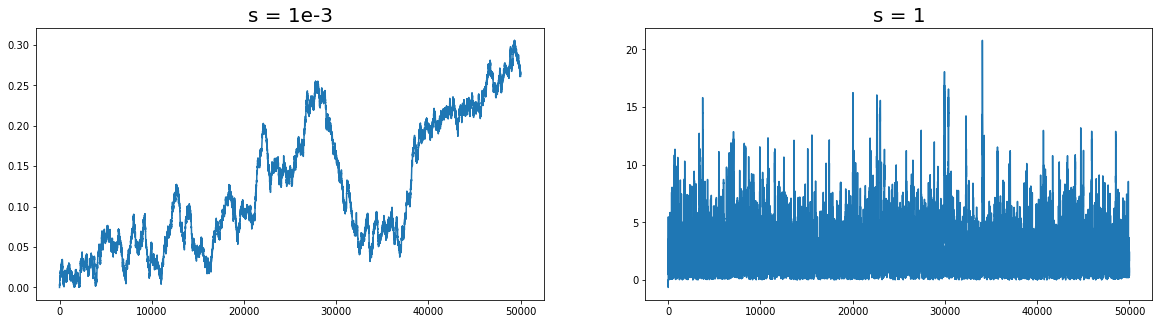

In [15]:
fig = plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.plot(range(nsamples), samples1)
plt.title('s = 1e-3', fontsize = 20)
plt.subplot(122)
plt.plot(range(nsamples), samples2)
plt.title('s = 1', fontsize = 20)
plt.show()

On remarque que pour $s = 1$ la chaîne de Markov "mélange" bien, ce qui n'est pas le cas pour $s = 10^{-3}$

C:\Users\Jarvis\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


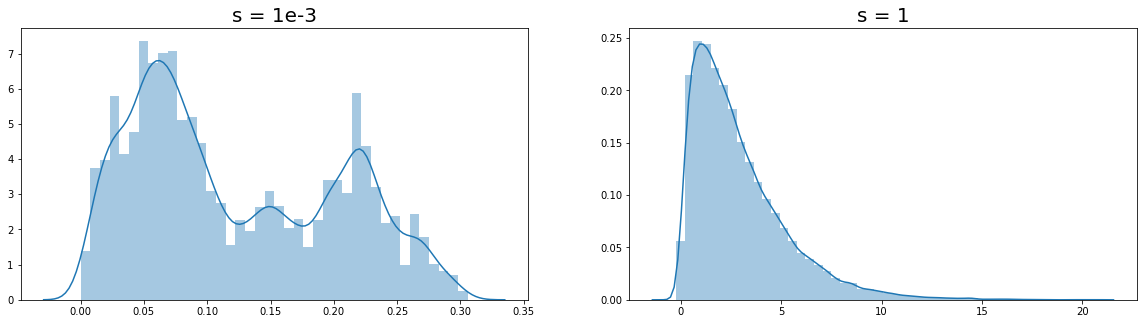

In [16]:
fig = plt.figure(figsize = (20, 5))
plt.subplot(121)
sns.distplot(samples1)
plt.title('s = 1e-3', fontsize = 20)
plt.subplot(122)
sns.distplot(samples2)
plt.title('s = 1', fontsize = 20)
plt.show()

Les histogrammes ci-dessus montrent que l'on approche bien la distribution $\chi^{2}(3)$ pour $s = 1$, ce qui n'est pas le cas pour $s = 10^{-3}$

## Question 3

On veut maintenant règler automatiquement le taux d'acceptation, on a remarqué dans les expériences précédentes que $s$ l'écart-type de la distribution instrumentale utilisée influence beaucoup le taux d'acceptation. L'idée maintenant est de commencer avec un grand écart-type et de le diminuer au cours du temps jusqu'à atteindre un taux d'acceptation proche de $0.5$ puisqu'on est en dimension $1$, pour cela on garde une moyenne mobile du taux d'acceptation sur une plage de $100$ échantillons simulés.

In [42]:
s = 10

In [83]:
from collections import deque

def adapt_mhsim(s, x0, nsamples, logpdf, proprnd):
    
    """
    Description
    --------------
    This function simulates an MCMC with an adaptive Metropolis-Hastings in order to get 
    samples from the distribution of log-probability distribution function logpdf.
    
    Paramaters
    --------------
    s        : Float, the initial standard deviation of the proposal distribution.
    x0       : Float, the initial state.
    nsamples : Int, the number of samples to generate.
    logpdf   : function, the log-probability distribution of the target distribution.
    proprnd  : function, the function that proposes the next value of the markov chain.
    
    Returns
    --------------
    samples  : List containing the simulated samples.
    rho_mean : Float, the mean acceptance ratio on a 100 range.
    s        : Float, The final standard deviation of the proposal distribution.
    """
    
    x = x0
    samples = [x]
    rho_values = deque(maxlen = 100)
    for i in range(1, nsamples):
        y = proprnd(s, x)
        rho = min(1, math.exp(logpdf(y) - logpdf(x)))
        if rho >= 1:
            x = y
            
        else:
            u = np.random.binomial(1, rho)
            x = u*y + (1 - u)*x
            
        samples.append(x)
        rho_values.append(rho)
        if len(rho_values) == 100:
            rho_mean = np.mean(rho_values)
            if rho_mean < 0.5:
                s /= 2
                rho_values = []
        
    return samples, rho_mean, s

In [84]:
samples, rho_mean, s = adapt_mhsim(s, x0, nsamples, logpdf, proprnd)

C:\Users\Jarvis\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


In [85]:
rho_mean

0.7531414327311952

In [86]:
s

1.25

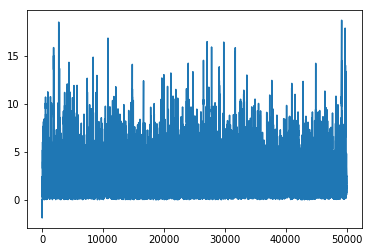

In [87]:
plt.plot(range(nsamples), samples)
plt.show()

C:\Users\Jarvis\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


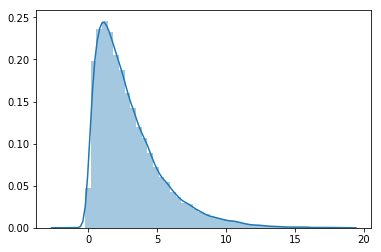

In [88]:
sns.distplot(samples)
plt.show()

We should be careful to the initial standard deviation we use, if it is too hig there is a risk of placing the current Markov chain point in a part of the space where the target probability distribution function is too low.

# Problème d'estimation

## Question 1

In [6]:
from scipy.integrate import odeint
y0 = np.array([1, 0])
x = np.array([0.6, 0.35, 0.15])
t = np.arange(1, 16)
def model(y, t, x):
    M = np.array([-x[0] - x[2], x[1], x[0], -x[1]]).reshape((2, 2))
    return np.dot(M, y)

In [7]:
odeint(model, y0, np.arange(1, 16), args = (x,))

array([[1.        , 0.        ],
       [0.53032529, 0.36077498],
       [0.35717071, 0.46942861],
       [0.28820887, 0.49071352],
       [0.25611613, 0.48224111],
       [0.2373135 , 0.46413196],
       [0.22353088, 0.44338915],
       [0.21185624, 0.4224273 ],
       [0.20125342, 0.40205711],
       [0.19134353, 0.38252968],
       [0.18197847, 0.36390187],
       [0.17309169, 0.3461641 ],
       [0.16464585, 0.32928496],
       [0.15661456, 0.31322676],
       [0.14897588, 0.29795093]])

In [8]:
def simulate_qts(x, t, s):
    return odeint(model, y0, t, args = (x,))[:, 1] + np.random.normal(0, s, len(t))

## Question 2

Construisons un vecteur d'observations $y = (y_1, \ldots, y_{15})$ pour le paramètre $x^* = (0.6, 0.35, 0.15)$

In [151]:
x = np.array([0.6, 0.35, 0.15])
s = 0.8
y = simulate_qts(x, np.arange(1, 16), s)

In [152]:
y

array([-0.68157722,  0.68291928, -0.30892456, -0.33406111,  0.66028562,
       -0.18451212,  0.66528698,  0.66091675, -1.07394402,  0.75884188,
        0.73337401, -0.17130821,  1.36135018,  0.18984017,  0.32296725])

In [153]:
loglikelihood = lambda x, y, s : - ((y - odeint(model, y0, t, args = (x,))[:, 1])**2).sum()/(2*s**2)

In [154]:
def posterior(x, y, s):
    
    for xi in x:
        if (xi < 0) or (xi > 1):
            return 0
        
    return np.exp(loglikelihood(x, y, s))

In [155]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def plot_posterior(index, value):
    
    fig = plt.figure(figsize = (50, 50))
    ax = fig.gca(projection='3d')

    # Make data.
    X1 = np.arange(0, 1, 0.1)
    X2 = np.arange(0, 1, 0.1)
    X1, X2 = np.meshgrid(X1, X2)
    Z = np.zeros(X1.shape)
    for i in range(X1.shape[0]):
        for j in range(X2.shape[1]):
            if index == 0:
                Z[i, j] = posterior([value, X1[i, j], X2[i, j]], y, s)
                
            elif index == 1:
                Z[i, j] = posterior([X1[i, j], value, X2[i, j]], y, s)
                
            elif index == 2:
                Z[i, j] = posterior([X1[i, j], X2[i, j], value], y, s)

    # Plot the surface.
    surf = ax.plot_surface(X1, X2, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Customize the z axis.
#     ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.05f'))
    ax.set

    # Add a color bar which maps values to colors.
    cbar = fig.colorbar(surf, shrink=0.5, aspect=5)
    cbar.ax.tick_params(labelsize = 50)
    ax.tick_params(axis='both', which='major', labelsize=50)
    if index == 0:
        ax.set_title('posterior distribution when setting x0 = %.2f' %value, fontsize=50)
        
    elif index == 1:
        ax.set_title('posterior distribution when setting x1 = %.2f' %value, fontsize = 50)
        
    elif index == 2:
        ax.set_title('posterior distribution when setting x2 = %.2f' %value, fontsize = 50)
        
    plt.show()

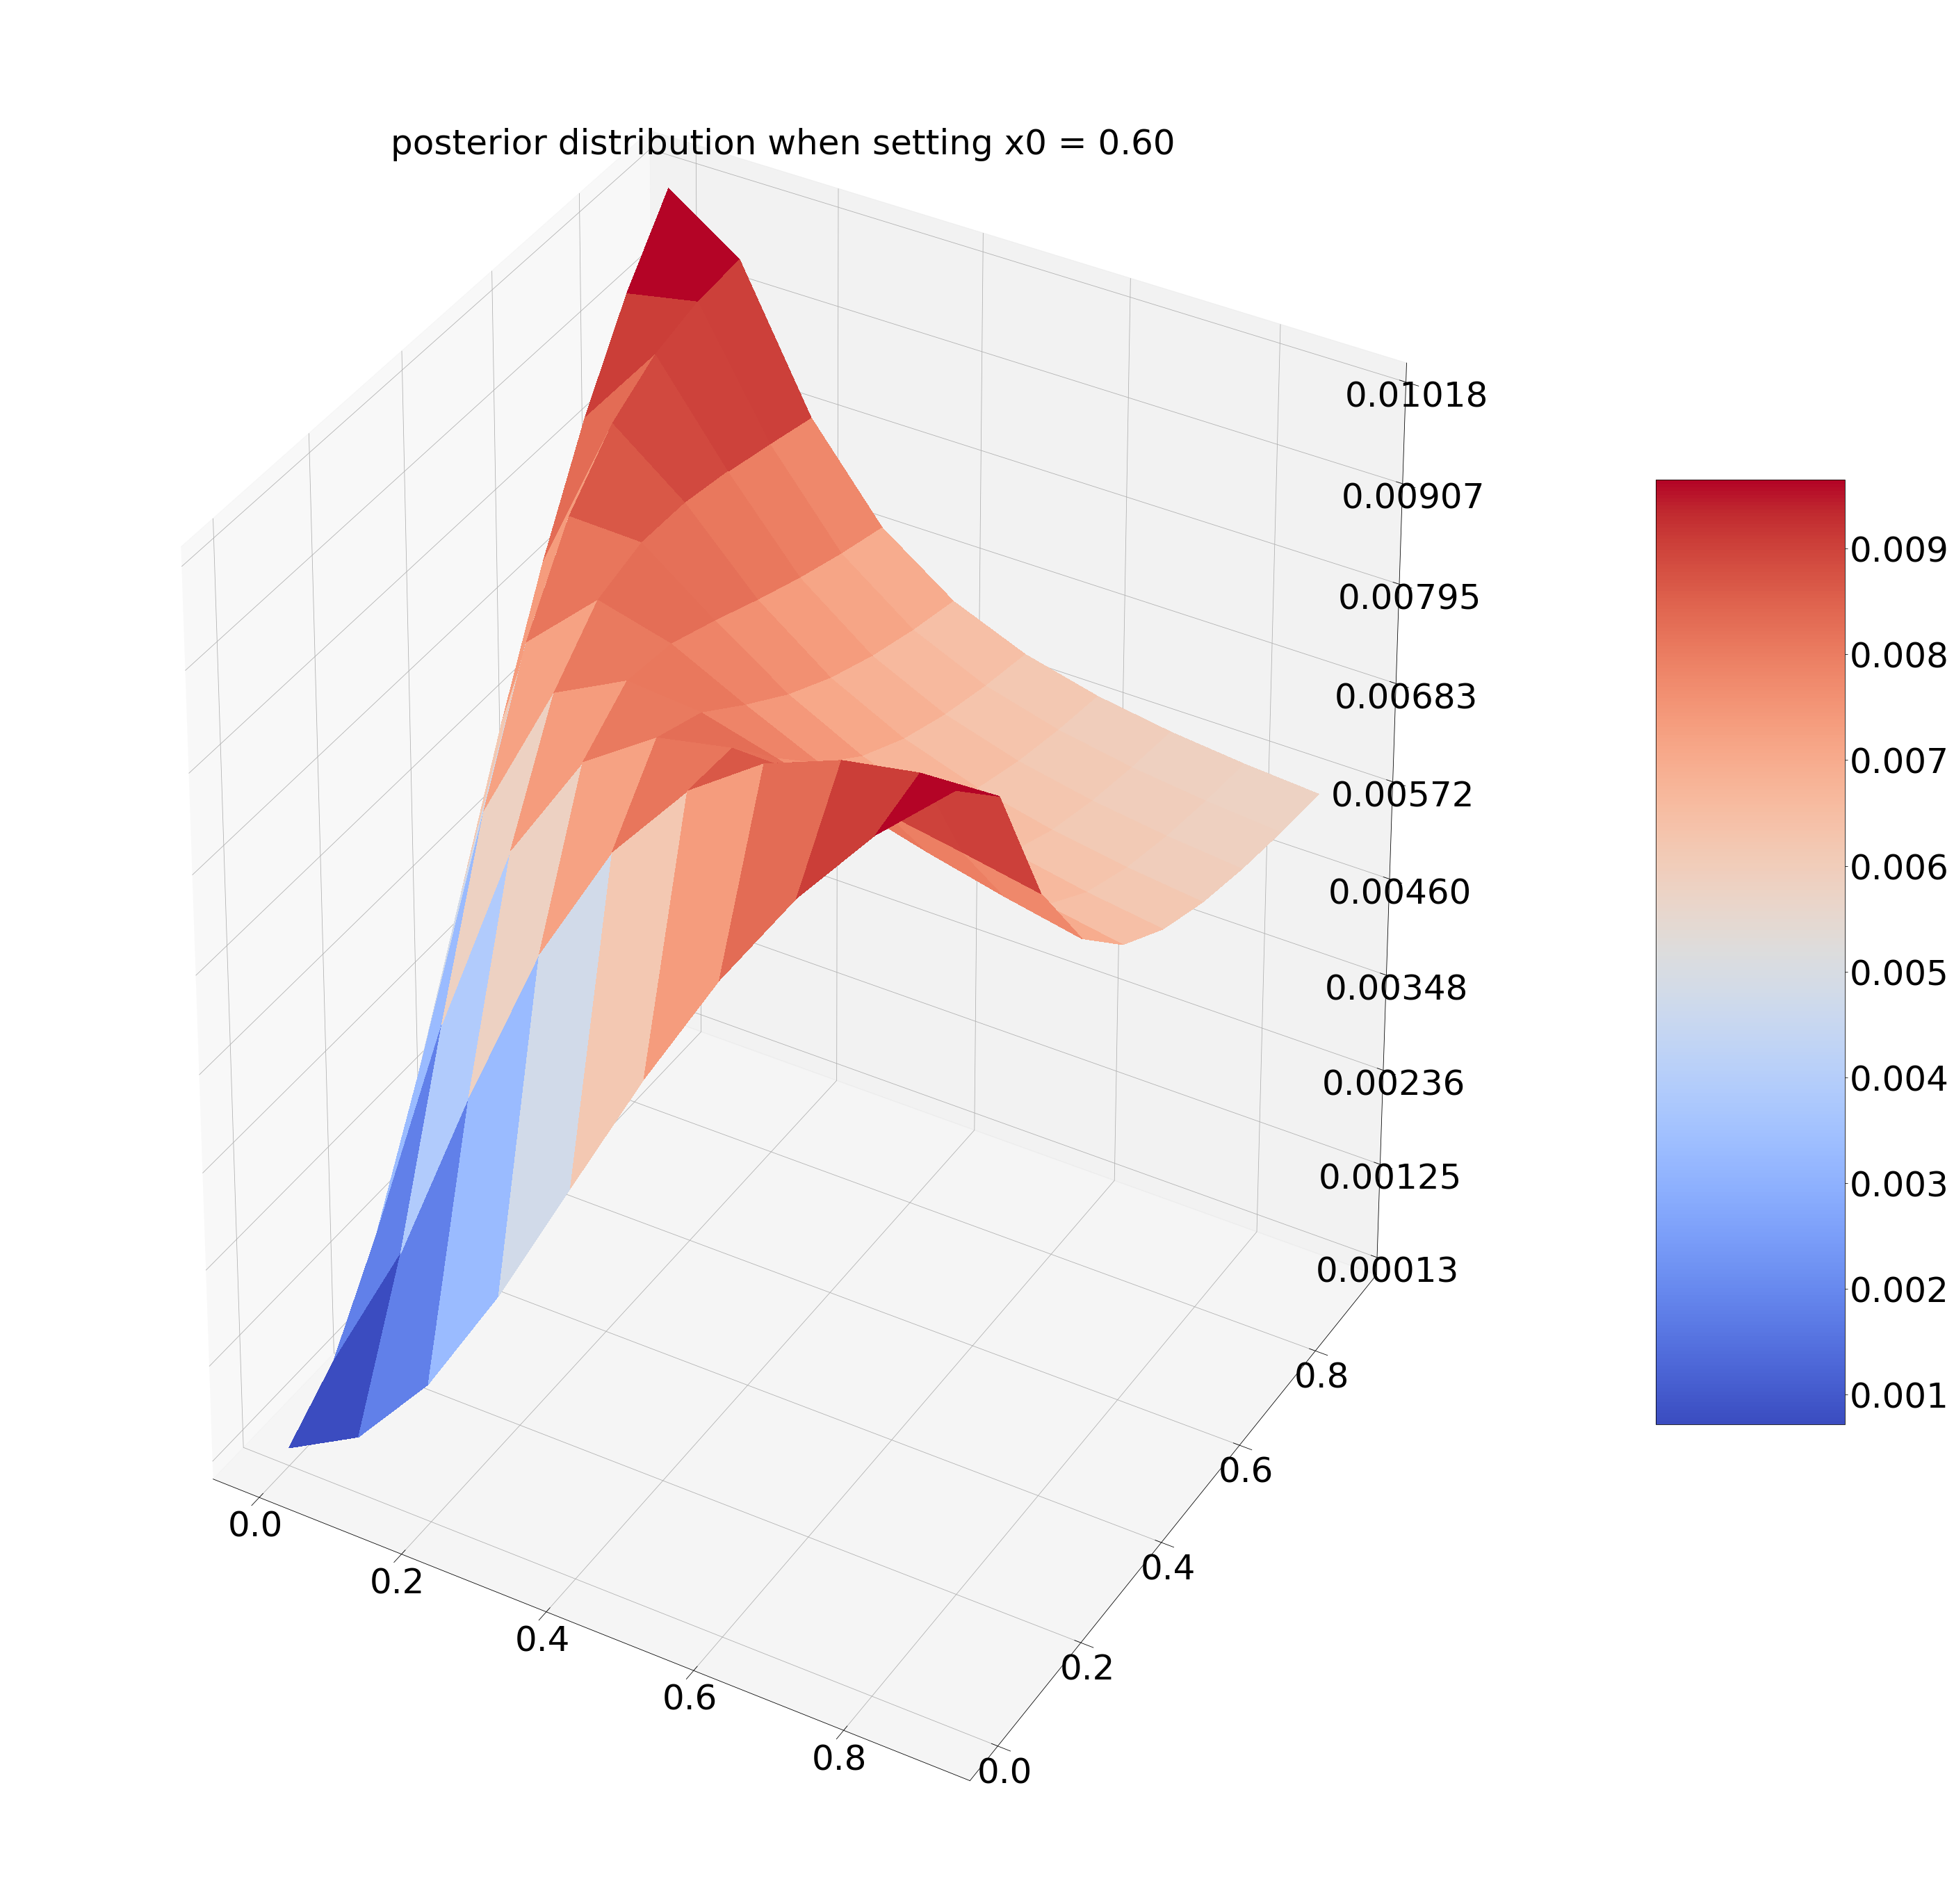

In [156]:
plot_posterior(0, 0.6)

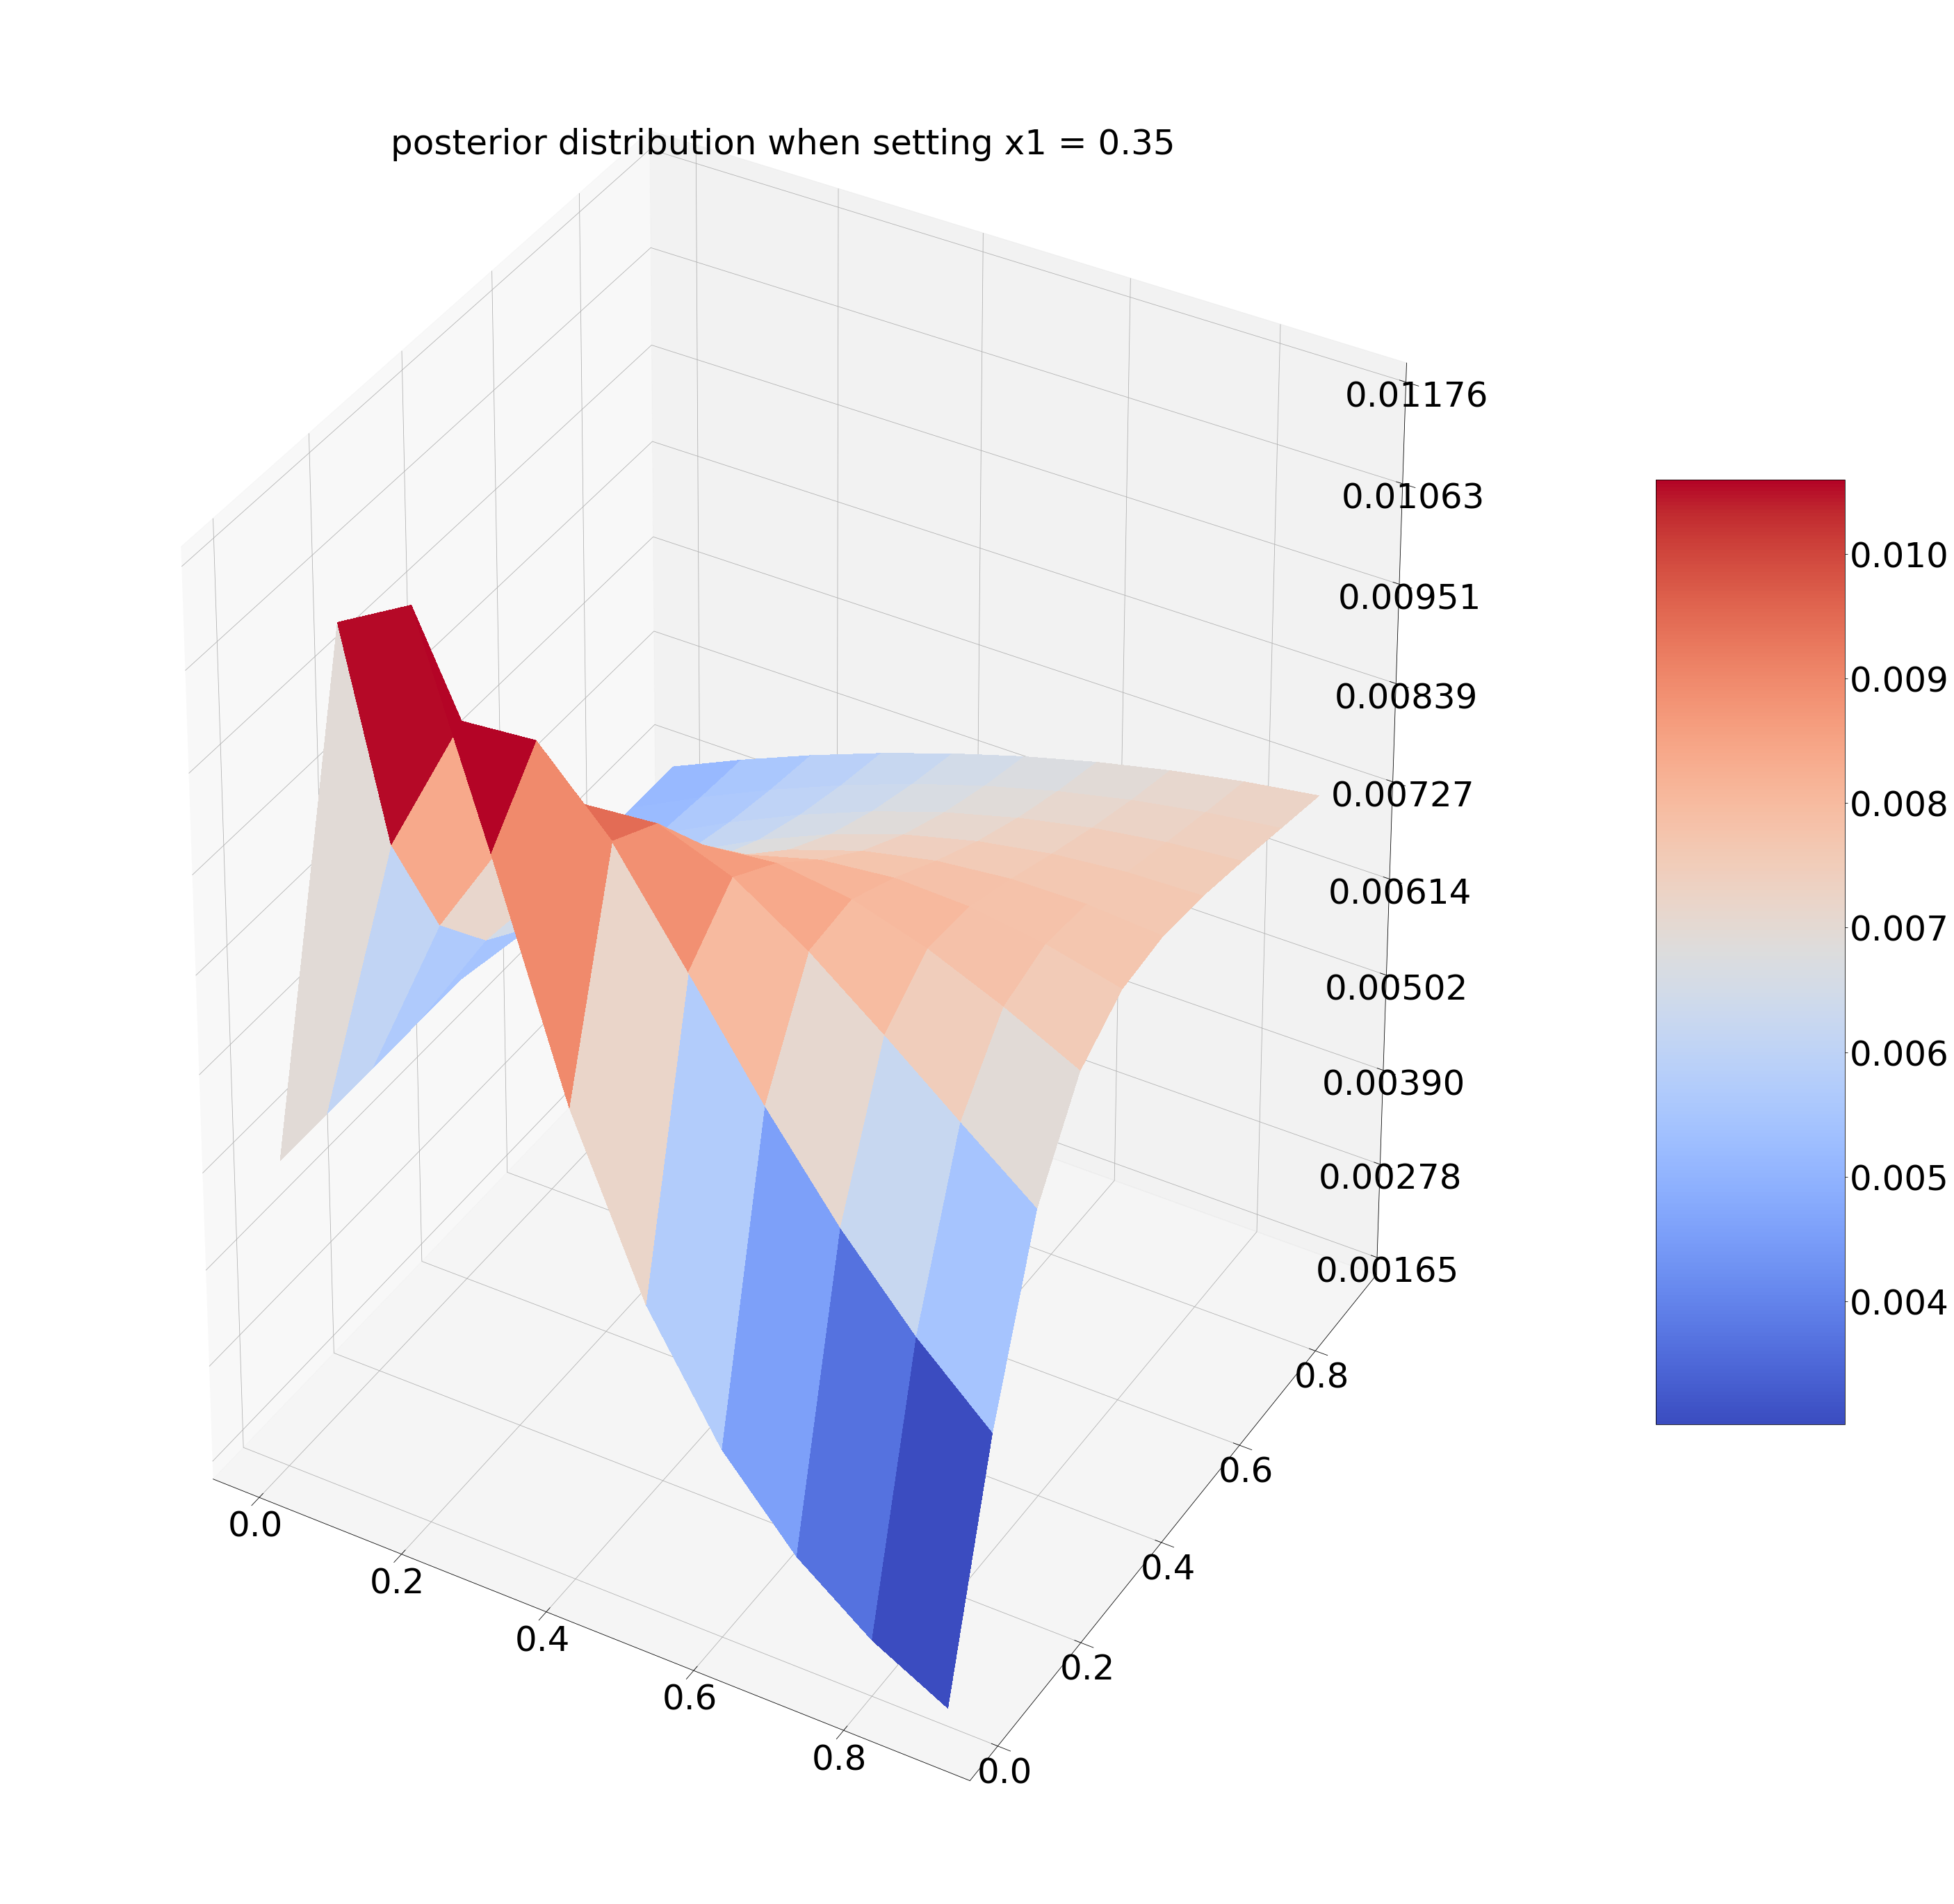

In [157]:
plot_posterior(1, 0.35)

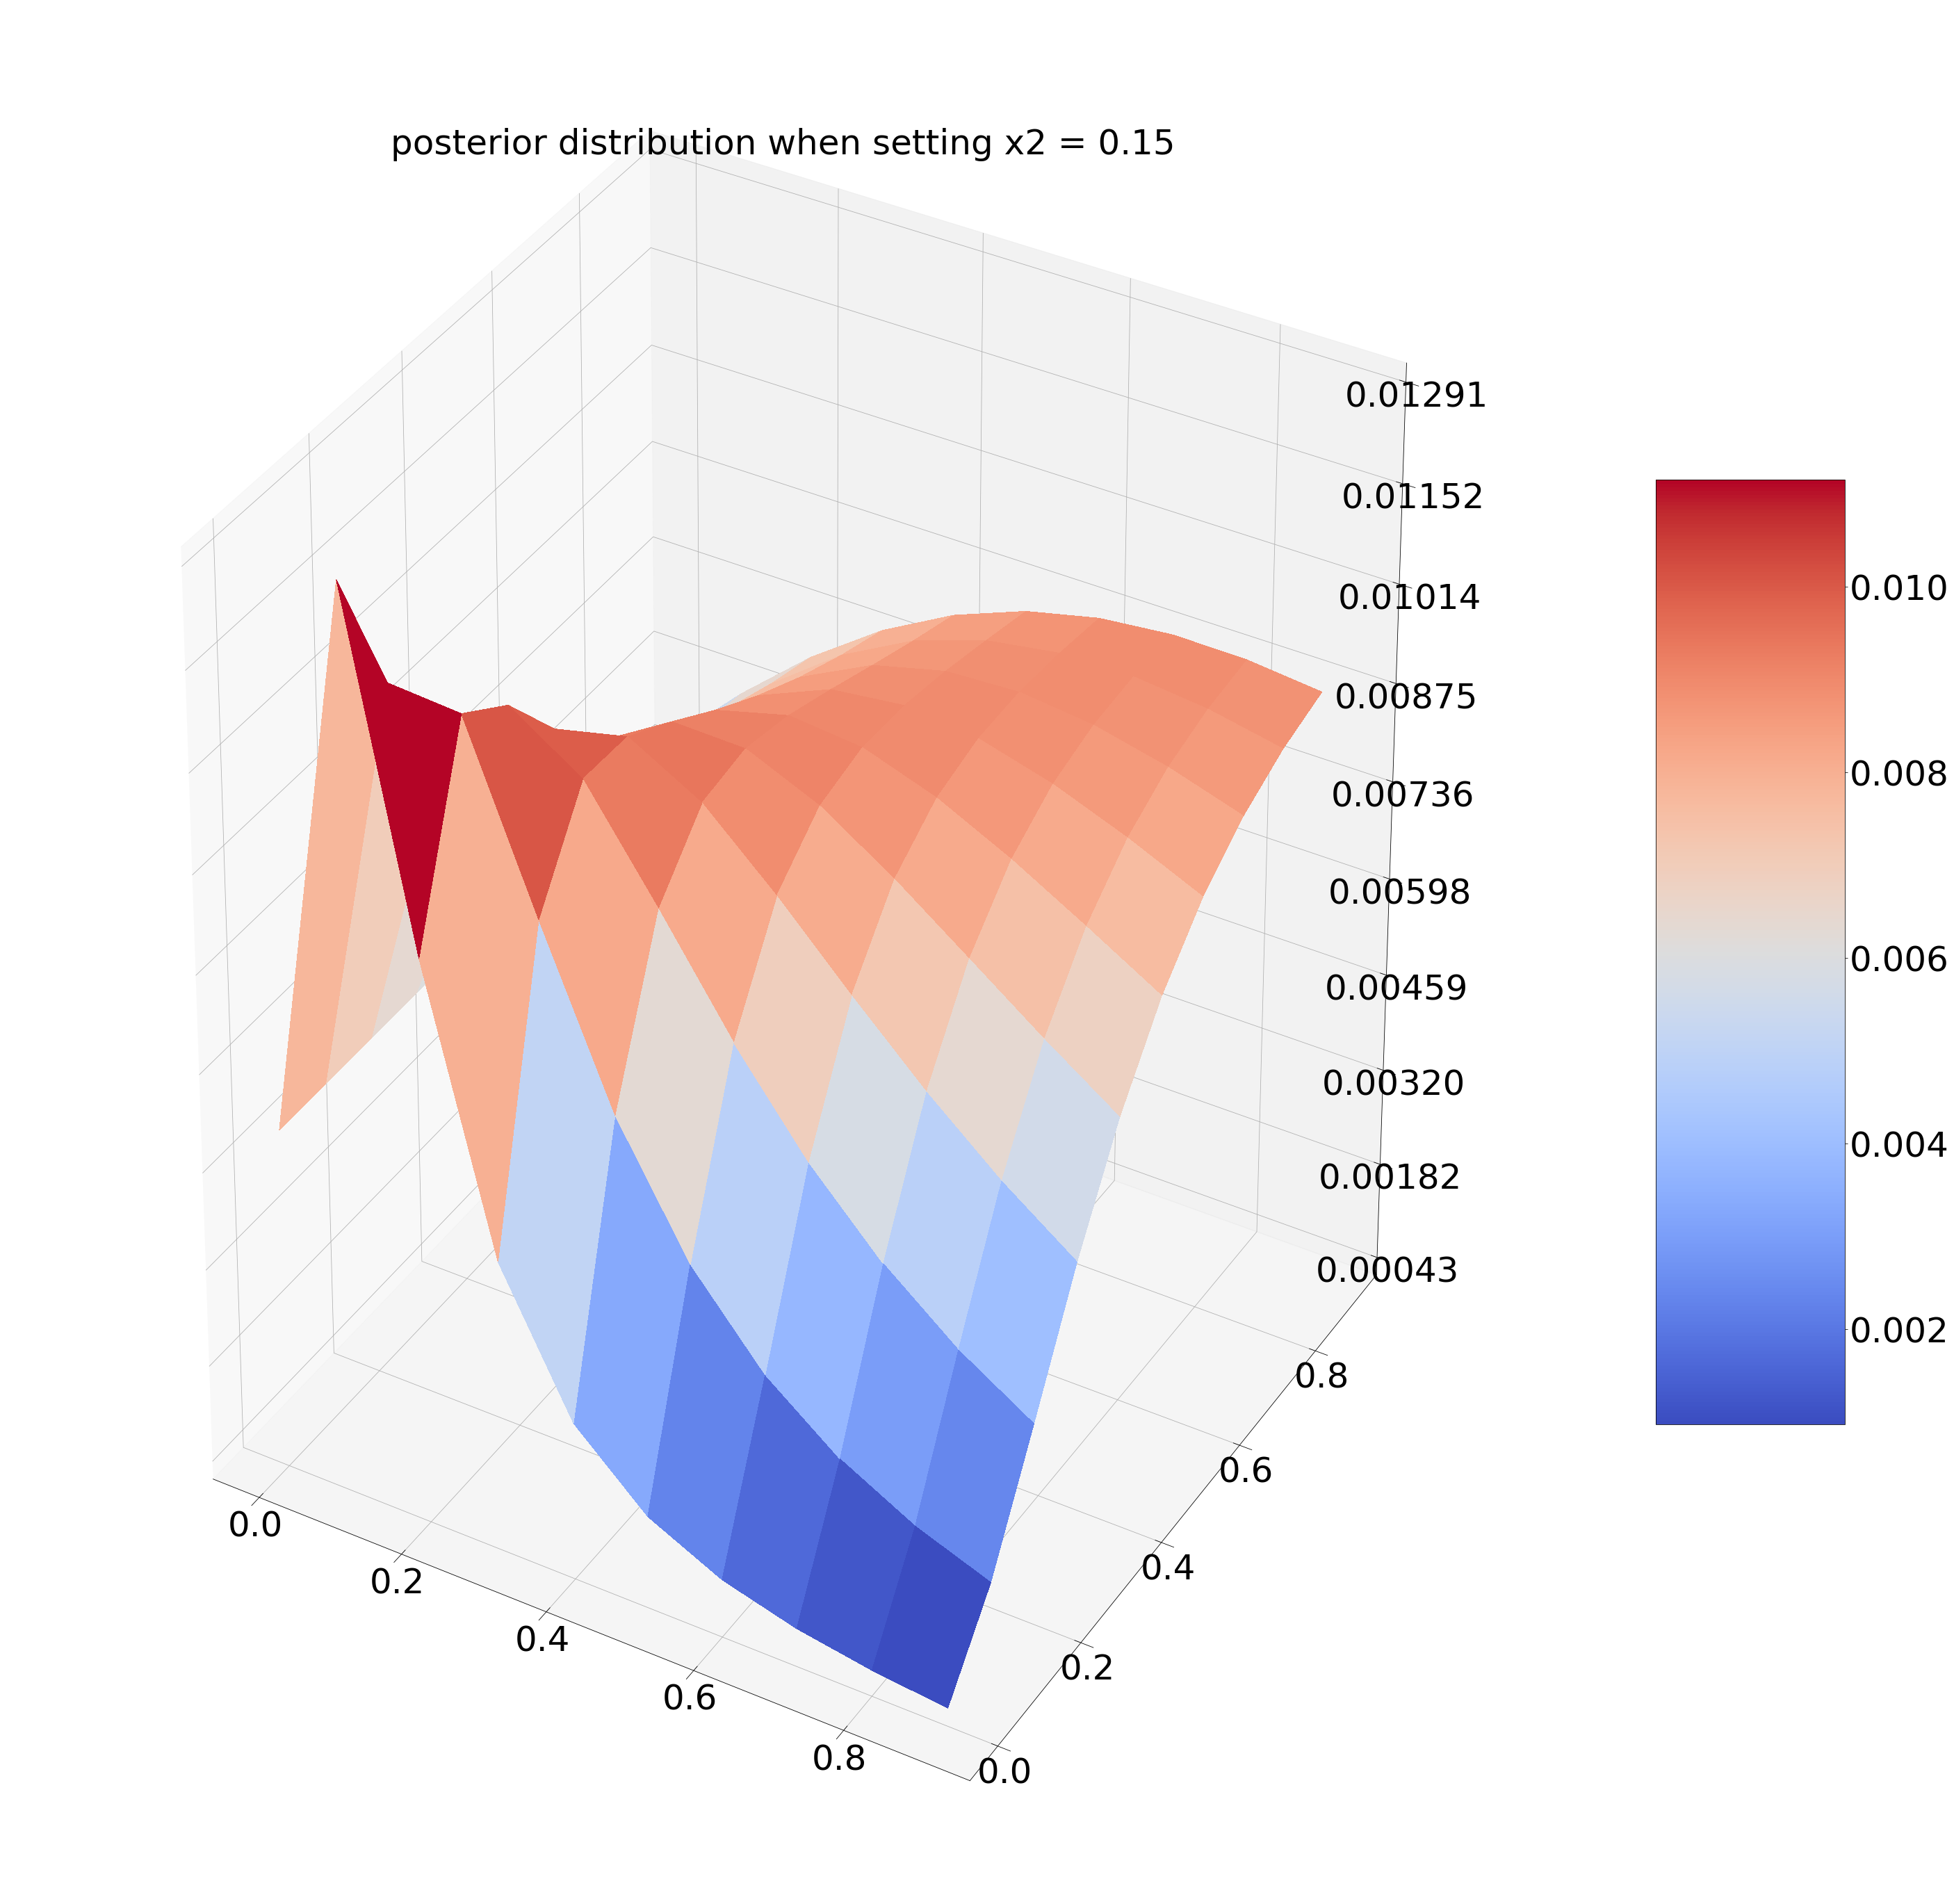

In [158]:
plot_posterior(2, 0.15)

Plus la variance du bruit d'observation est grand, plus nos surfaces graphiques sont plates. C'est normal car augmenter cette variance implique que l'incertitude concernant nos paramètres augmente aussi.

## Question 4

Ayant une loi à priori $X \sim \mathcal{U}\left([0, 1]^3 \right)$ suggère qu'on une utilise un random walk Metropolis-Hastings en prenant une loi instrumentale $Y|X \sim \mathcal{N}\left(X, \Sigma \right)$ où $\Sigma$ est une matrice de covariance diagonale isotropique.

In [194]:
s = 0.5
x0 = 0.5*np.ones(3)
nsamples = 50000
proprnd = lambda s, x : x + s*np.dot(np.eye(3), np.random.multivariate_normal(np.zeros(3), np.eye(3)))

In [195]:
def mh(x0, nsamples, proprnd, s_init, s_final, decay_rate = 1e-3):
    
    x = x0
    samples = [x]
    rho_mean = 0
    s = s_init
    for i in range(1, nsamples):
        x_next = proprnd(s, x)
        rho = min(1, posterior(x_next, y, s)/(posterior(x, y, s) + 1e-200))
        if rho >= 1:
            x = x_next
            
        else:
            u = np.random.binomial(1, rho)
            x = u*x_next + (1 - u)*x
            
        samples.append(x)
        rho_mean += rho
        s = s_final + (s_init - s_final)*math.exp(-i*decay_rate)
        
    return samples, rho_mean/(nsamples - 1)

In [196]:
samples, rho_mean = mh(x0, nsamples, proprnd, s, 0.01, 1*1e-5)

In [197]:
rho_mean

0.17269701741951335

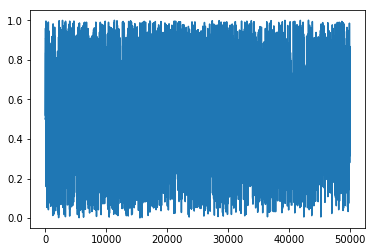

In [200]:
plt.plot(range(nsamples), np.array(samples)[:, 0])

C:\Users\Jarvis\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


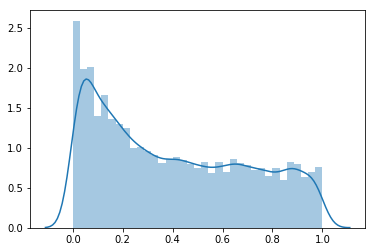

In [203]:
sns.distplot(np.array(samples)[:, 2])